In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import numpy as np
import tensorflow as tf
import os.path as osp
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from collections import defaultdict

In [3]:
from tflearn.layers.core import fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.fundamentals.inspect import count_trainable_parameters

In [4]:
from general_tools.notebook.tf import reset_tf_graph
from geo_tool import Point_Cloud, Mesh
from helper import plot_mesh, load_diff_maps, load_pclouds_of_shapes,\
pose_labels_and_original_index, load_gt_latent_params, load_meshes,\
make_data, prepare_train_test_val, load_pclouds_of_shapes

In [5]:
from scipy.io import loadmat, savemat
from tflearn import is_training

In [6]:
def consistent_bases(sync_bases_file, n_cons, n_shapes, debug=False):
    synced_bases = loadmat(synced_bases_file)
    synced_bases = synced_bases['sync_bases']
    synced_bases = synced_bases[:, :n_cons]
    if debug:
        temp = []
        n_evecs  = int(synced_bases.shape[0]/n_shapes)
        for i in range(0, synced_bases.shape[0], n_evecs):
            temp.append(synced_bases[i:i+n_evecs])
        temp = np.array(temp)
        print np.all(synced_bases.reshape((n_shapes, -1, n_cons)) == temp)
    return synced_bases.reshape((n_shapes, -1, n_cons))

def pc_net(n_pc_points):
    with tf.variable_scope('pc_based_net') as scope:
        feed_pl = tf.placeholder(tf.float32, shape = (None, n_pc_points, 3) )
        labels_pl = tf.placeholder(tf.int64, shape=[None])                           
        layer = encoder_with_convs_and_symmetry_new(feed_pl, n_filters=[64, 128], b_norm=False)
        layer = fully_connected(layer, 64, activation='relu', weights_init='xavier')
        logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
    return feed_pl, labels_pl, logits

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
members_per_class = 50
seed = 42
n_pose_classes = 8
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)

orinal_class_size = 250
n_pc_points = 2048
do_pose_clf = False
do_unsup_clf = True
normalize_pcs = False
mean_norm_diffs = True

n_shapes = members_per_class * n_pose_classes

n_cons = 45

In [11]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/'
diff_file = osp.join(top_data_dir, '%d_50_25_20_consistent_diffs_clique_net.mat' % members_per_class)
synced_bases_file = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/50_50_synced_bases_clique_net.mat'

In [15]:
c_bases = consistent_bases(synced_bases_file, n_cons, n_shapes)
diff_shape = (len(c_bases), c_bases[0].shape[1], c_bases[0].shape[1])
in_diffs = np.zeros(shape=diff_shape)

diag_of_diffs = []
for i in xrange(len(c_bases)):
    in_diffs[i] = c_bases[i].T.dot(c_bases[i])
    diag_of_diffs.append(np.diagonal(in_diffs[i]))
    # np.diagonal(in_diffs[i], offset=1)
diag_of_diffs = np.array(diag_of_diffs)

In [237]:
# row_pos = np.repeat(np.arange(diff_dims[0]), diff_dims[1]).reshape(diff_dims)
# col_pos = np.repeat(np.arange(diff_dims[1]), diff_dims[0]).reshape(diff_dims[1], diff_dims[0]).T
# row_pos = row_pos.astype(np.float32)
# col_pos = col_pos.astype(np.float32)
# row_pos *= 0.01
# col_pos *= 0.01

In [238]:
# diffs_with_pos = np.zeros(shape=in_diffs.shape + (3,))
# for i, d in enumerate(in_diffs):
#     diffs_with_pos[i, :, :, 0] = d
#     diffs_with_pos[i, :, :, 1] = row_pos
#     diffs_with_pos[i, :, :, 2] = col_pos

In [17]:
pose_labels, original_idx = pose_labels_and_original_index(n_shapes, members_per_class, orinal_class_size)
gt_latent_params = load_gt_latent_params(top_data_dir)
gt_latent_params = gt_latent_params[original_idx]
in_pcs = load_pclouds_of_shapes(top_data_dir, members_per_class, normalize=normalize_pcs, n_pc_points=n_pc_points)

In [280]:
# in_meshes = load_meshes(original_idx + 1)
# uniform_pcs = []
# for m in in_meshes:
#     uniform_pcs.append(m.sample_faces(n_pc_points)[0])
# uniform_pcs = np.array(uniform_pcs)

In [107]:
# k = 99
# Point_Cloud(uniform_pcs[k]).plot(in_u_sphere=False);
# Point_Cloud(in_pcs[k]).plot(in_u_sphere=False);

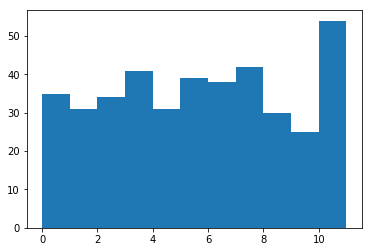

In [19]:
seed = 3
if do_pose_clf:
    n_classes = n_pose_classes
    in_labels = pose_labels
elif do_unsup_clf:    
    n_classes = 12
    unsup_clf = KMeans(n_clusters=n_classes, random_state=seed)
    in_labels = unsup_clf.fit_predict(gt_latent_params)
    plt.hist(in_labels, bins=np.arange(n_classes))
else:
    assert(False)

splits = prepare_train_test_val(n_shapes, in_labels, train_per, test_per, seed=seed)

In [163]:
use_pc = False

if use_pc:
    feeds = in_pcs
else:
    feeds = in_diffs

    in_data = make_data(splits, feeds, in_labels)

# in_diffs -= np.mean(in_diffs, axis=0)

train_data = in_data['train']
val_data = in_data['val']
test_data = in_data['test']

if not use_pc and mean_norm_diffs:
    diff_mu = np.mean(train_data.feed, axis=0)
    train_data.feed -= diff_mu    
#     diff_sigma = np.std(train_data.feed, axis=0)
#     train_data.feed /= diff_sigma
    test_data.feed -= diff_mu
#     test_data.feed /= diff_sigma
    val_data.feed -= diff_mu
#     val_data.feed /= diff_sigma
    
#     test_data.feed -= np.mean(test_data.feed, axis=0)
#     val_data.feed -= np.mean(val_data.feed, axis=0)

['feed', 'labels', 'ids']
['feed', 'labels', 'ids']
['feed', 'labels', 'ids']


In [170]:
arch = 'mlp'

reset_tf_graph()

if use_pc: 
    feed_pl, labels_pl, logits = pc_net(n_pc_points)
else:
    in_shape = in_data['train'].feed[0].shape
    with tf.variable_scope('diff_based_net') as scope:
        feed_pl = tf.placeholder(tf.float32, shape = (None, ) + in_shape)
        labels_pl = tf.placeholder(tf.int64, shape=[None])        
        if arch == 'mlp':
            layer = fully_connected(feed_pl, 200, activation='relu', weights_init='xavier')
            logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
        
        elif arch == 'conv':
            layer = tf.expand_dims(feed_pl, -1)
            layer = conv_2d(layer, nb_filter=25, filter_size=2, activation='relu')
#             layer = tf.nn.dropout(layer, 0.1)
#             layer = max_pool_2d(layer, kernel_size=2)
            layer = conv_2d(layer, nb_filter=40, filter_size=2, activation='relu')    
            layer = conv_2d(layer, nb_filter=40, filter_size=2, activation='relu')
#             layer = tf.nn.dropout(layer, 0.1)
#             layer = max_pool_2d(layer, kernel_size=2)
#             layer = conv_2d(layer, nb_filter=2, filter_size=2, activation='relu')
#             layer = max_pool_2d(layer, kernel_size=2)
#             layer = fully_connected(layer, 6, activation='relu', weights_init='xavier')
            logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
        else:
            assert(False)

print count_trainable_parameters()

407612


In [171]:
prediction = tf.argmax(logits, axis=1)
target_ = labels_pl
correct_pred = tf.equal(prediction, target_)
avg_accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
one_hot_labels = tf.one_hot(labels_pl, depth=n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
loss = tf.reduce_mean(cross_entropy)

if use_pc:
    learning_rate = 0.005
    batch_size = 50
    n_epochs = 1000
else:
    learning_rate = 0.005
    batch_size = 50
    n_epochs = 1000

opt = tf.train.AdamOptimizer(learning_rate)
opt_step = opt.minimize(loss)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [172]:
train_losses = []
val_losses = []
test_losses = []
batches_for_epoch = train_data.n_examples / batch_size
train_res = defaultdict(list)

In [177]:
for epoch in range(n_epochs):    
    is_training(True, session=sess)
    for _ in range(batches_for_epoch):        
        batch_d, batch_l, _ = train_data.next_batch(batch_size)
        feed_dict = {feed_pl:batch_d, labels_pl:batch_l}
        sess.run([opt_step, loss, avg_accuracy], feed_dict=feed_dict)
    is_training(False, session=sess)
    print epoch,
    
    for s in ['train', 'test', 'val']:
        feed_dict = {feed_pl:in_data[s].feed, labels_pl:in_data[s].labels}
        r = sess.run([avg_accuracy], feed_dict=feed_dict)
        train_res[s].append(r)
        print r,
    print

0 [0.99000007] [0.80000007] [0.65000004]
1 [0.99000007] [0.78333342] [0.65000004]
2 [0.98666674] [0.76666677] [0.65000004]
3 [0.98666674] [0.78333342] [0.67500007]
4 [0.99000007] [0.78333342] [0.67500007]
5 [0.99000007] [0.76666677] [0.65000004]
6 [0.99000007] [0.81666672] [0.65000004]
7 [0.98666674] [0.76666671] [0.65000004]
8 [0.9933334] [0.80000007] [0.67500007]
9 [0.99000007] [0.75000006] [0.65000004]
10 [0.99000007] [0.80000007] [0.65000004]
11 [0.99000007] [0.78333342] [0.67500007]
12 [0.98666674] [0.80000007] [0.67500007]
13 [0.99000007] [0.76666677] [0.65000004]
14 [0.99000007] [0.80000007] [0.67500007]
15 [0.98666674] [0.76666677] [0.67500007]
16 [0.99000007] [0.81666672] [0.65000004]
17 [0.98666674] [0.76666677] [0.67500007]
18 [0.99000007] [0.78333342] [0.67500007]
19 [0.99000007] [0.78333342] [0.65000004]
20 [0.98666674] [0.75000006] [0.65000004]
21 [0.98666674] [0.80000007] [0.67500007]
22 [0.99000007] [0.80000007] [0.67500007]
23 [0.99000007] [0.80000007] [0.65000004]
24 

In [178]:
val_maximizers = np.where(train_res['val'] == np.max(train_res['val']))[0]
print val_maximizers

[ 922  941  958  961  972  974  985 1000 1006 1012 1015 1019 1020 1022 1023
 1026 1027 1028 1030 1034 1039 1041 1047 1048 1050 1054 1057 1062 1067 1070
 1072 1075 1076 1078 1079 1081 1083 1085 1086 1087 1088 1090 1091 1094 1096
 1098 1100 1101 1102 1103 1105 1108 1111 1112 1114 1116 1118 1119 1121 1122
 1124 1127 1128 1129 1130 1131 1133 1134 1135 1136 1138 1142 1146 1148 1149
 1151 1152 1153 1155 1156 1157 1158 1159 1161 1162 1163 1165 1167 1169 1171
 1172 1173 1174 1175 1176 1177 1178 1180 1182 1183 1184 1185 1189 1191 1192
 1193 1194 1196 1197 1198 1201 1202 1204 1208 1209 1211 1212 1214 1216 1217
 1221 1222 1223 1224 1225 1226 1227 1229 1230 1231 1233 1234 1235 1236 1239
 1240 1241 1242 1243 1244 1246 1247 1248 1250 1252 1253 1254 1255 1257 1259
 1260 1262 1264 1266 1267 1268 1269 1270 1272 1274 1275 1276 1277 1278 1279
 1281 1282 1283 1284 1285 1287 1288 1292 1294 1295 1296 1297 1298 1299 1300
 1301 1303 1304 1305 1307 1308 1309 1310 1312 1313 1314 1316 1318 1319 1321
 1323 1324 1

[ 0.80000007]
428


0.70455498

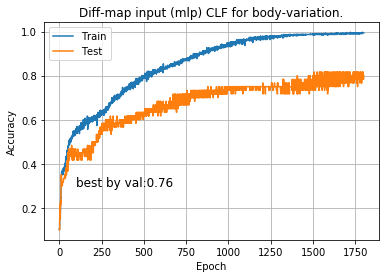

In [181]:
plt.plot(train_res['train'])
plt.plot(train_res['test'])
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

if use_pc:
    title_tag = 'Raw input'
else:
    title_tag = 'Diff-map input (%s)' % (arch,)

plt.title('%s CLF for body-variation.'% (title_tag, ))

val_maximizers = np.where(train_res['val'] == np.max(train_res['val']))[0]
val_best = np.mean(np.array(train_res['test'])[val_maximizers])
plt.text(100, 0.3, 'best by val:%.2f' % (val_best,), fontsize=12);

print np.array(train_res['test'])[val_maximizers[-1]]

print len(val_maximizers)
np.mean(np.array(train_res['test'])[int(n_epochs - n_epochs*0.05):])

In [340]:
s = 'test'

feed_dict = {feed_pl:in_data[s].feed, labels_pl:in_data[s].labels}

r = sess.run([correct_pred], feed_dict=feed_dict)

(array([ 3.,  5.,  2.,  5.,  5.,  6.,  4.,  5.,  3.,  4.,  2.,  3.]),
 array([  0.        ,   0.91666667,   1.83333333,   2.75      ,
          3.66666667,   4.58333333,   5.5       ,   6.41666667,
          7.33333333,   8.25      ,   9.16666667,  10.08333333,  11.        ]),
 <a list of 12 Patch objects>)

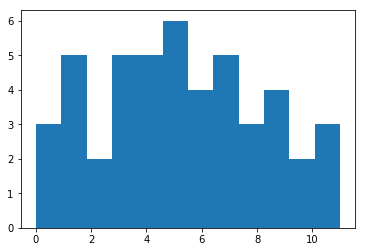

In [341]:
plt.hist(in_data[s].labels[r], bins=n_classes)

(array([ 2.,  2.,  2.,  2.,  3.,  4.,  5.,  2.,  2.,  3.,  1.,  2.]),
 array([  0.        ,   0.91666667,   1.83333333,   2.75      ,
          3.66666667,   4.58333333,   5.5       ,   6.41666667,
          7.33333333,   8.25      ,   9.16666667,  10.08333333,  11.        ]),
 <a list of 12 Patch objects>)

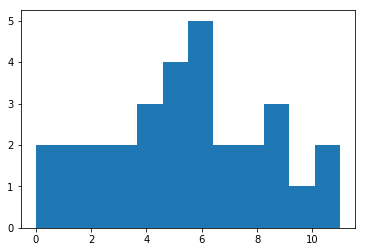

In [333]:
# in_data[s].labels[r]
plt.hist(in_data[s].labels[r], bins=n_classes)

In [195]:
# train_data.feed.shape

(320, 50, 25)

In [65]:
in_class_p = 0.01
out_class_p = 0.01
p_matrix = np.ones(shape = (n_classes, n_classes)) * out_class_p
np.fill_diagonal(p_matrix, in_class_p)
adj = SBM_from_class_labels(sorted(in_labels), p_matrix)

500

In [48]:
import random
import numpy as np

def SBM_from_class_labels(vertex_labels, p_matrix):
    n_vertices = len(vertex_labels)
    adjacency = np.zeros(shape=(n_vertices, n_vertices), dtype=np.bool)
    for row, _row in enumerate(adjacency):
        for col, _col in enumerate(adjacency[row]):
            community_a = vertex_labels[row]
            community_b = vertex_labels[col]
            
            p = random.random()
            val = p_matrix[community_a][community_b]

            if p <= val:
                adjacency[row][col] = 1
                adjacency[col][row] = 1
    return adjacency

In [67]:
# feed_dict = {diffs_pl:test_data.diff_maps, labels_pl:test_data.labels}
# pred = sess.run(prediction, feed_dict=feed_dict)
# missed = np.where(test_data.labels != pred)
# pred[missed]
# test_data.labels[missed]
# test_data.ids[missed]

In [207]:
grid_scaler = np.arange(np.prod(diff_dims)).reshape(diff_dims)
loc_scaled_diffs = []
for d in in_diffs:
    loc_scaled_diffs.append(d + grid_scaler)

In [ ]:
# d = in_diffs[0]
# # plt.imshow(d)
# # d = np.hstack((d, np.zeros(50).reshape(-1, 1)))
# # print d.shape
# # # coeffs = pywt.dwt2(d, 'haar')
# # # print coeffs[0].shape
# # cc = (d[0:25,0:13], (d[0:25, 13:], d[25:, 0:13], d[25:,13:]))
# # lala = pywt.idwt2(cc, 'haar')
# # # plt.imshow(lala)
# # plt.imshow(lala)
# # plt.imshow(np.bmat([coeffs[0], coeffs[1][0]],[coeffs[1][1], coeffs[1][2]]))
# # plt.imshow(in_diffs[-1])
# # len(coeffs)
# # coeffs[1][2].shape

# import pywt

# haar_diffs = []
# for d in in_diffs:
# #     coeffs = pywt.dwt2(d, 'haar')
# #     haar_diffs.append(coeffs[0])

#     dd = np.hstack((d, np.zeros(50).reshape(-1, 1)))
#     cc = (dd[0:25,0:13], (dd[0:25, 13:], dd[25:, 0:13], dd[25:,13:]))
#     haar_diffs.append(pywt.idwt2(cc, 'haar'))

# #     coeffs = [d, (d, d, d)]
# #     haar_diffs.append(pywt.idwt2(coeffs, 'haar'))


# haar_diffs = np.array(haar_diffs)

In [ ]:


# for epoch in range(n_epochs):
#     for _ in range(batches_for_epoch):        
#         batch_d, batch_l, batch_dd = train_data.next_batch(batch_size)
#         feed_dict = {feed_pl_1:batch_d, labels_pl:batch_l, feed_pl_2:batch_dd}
#         sess.run([opt_step, loss, avg_accuracy], feed_dict=feed_dict)
    
#     print epoch,
#     for s in ['train', 'test', 'val']:
#         feed_dict = {feed_pl_1:in_data[s].feed, labels_pl:in_data[s].labels, feed_pl_2:in_data[s].ids}
#         r = sess.run([avg_accuracy], feed_dict=feed_dict)        
#         train_res[s].append(r)
#         print r,
#     print


# from tf_lab.data_sets.numpy_dataset import NumpyDataset
# def make_data_mixed(in_data, in_pc, class_labels, in_diff):
#     res = dict()
#     for s in ['train', 'test', 'val']:
#         idx = in_data[s].copy()        
#         res[s] = NumpyDataset([in_pc[idx], class_labels[idx], in_diff[idx]], ['feed', 'labels', 'ids'])
#     return res

# in_data = make_data_mixed(splits, in_pcs, in_labels, in_diffs)

In [ ]:
# is_directed = False
# n_shapes
# from geo_tool.utils.graph_generators import gnm_random_graph
# from geo_tool import Graph

# g = gnm_random_graph(n_shapes, n_shapes*4, directed=is_directed)
# print Graph.connected_components(g)[0]
# gg = Graph(g, is_directed)


# # splits['train']

# in_class_p = 0.01
# out_class_p = 0.05
# p_matrix = np.ones(shape = (n_classes, n_classes)) * out_class_p
# np.fill_diagonal(p_matrix, in_class_p)


# adj = SBM_from_class_labels(in_labels, p_matrix)

# for s in ['test', 'val']:
#     for idx in splits[s]:
#         adj[idx,:] = 0
#         adj[:,idx] = 0
        
# plt.imshow(g.toarray())
# plt.imshow(adj)

# mixed = np.array(g.toarray() + adj, dtype=bool)
# savemat('50_mixed_net.mat', {'W': mixed} )

In [ ]:
#     labels_pl = tf.placeholder(tf.int64, shape=[None])
#     diff_dims = (60, 30)
#     feed_pl_1 = tf.placeholder(tf.float32, shape = (None, n_pc_points, 3) )
#     feed_pl_2 = tf.placeholder(tf.float32, shape = (None, ) + diff_dims)
    
#     layer_pc = encoder_with_convs_and_symmetry_new(feed_pl_1, n_filters=[64, 128], b_norm=False)
    
    
#     layer = conv_2d(tf.expand_dims(feed_pl_2, -1), nb_filter=4, filter_size=4, activation='relu')
#     layer = max_pool_2d(layer, kernel_size=2)
#     layer = conv_2d(layer, nb_filter=4, filter_size=3, activation='relu')
#     layer = max_pool_2d(layer, kernel_size=2)
#     layer = fully_connected(layer, 6, activation='relu', weights_init='xavier')    
#     layer_diff = fully_connected(layer, 64, activation='relu', weights_init='xavier')
#     layer = tf.concat([layer_pc, layer_diff], axis=1)    
#     layer = fully_connected(layer, 32, activation='relu', weights_init='xavier')
#     logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
    